## Setup

In [ ]:
## Libraries
# lightkurve
#import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
#import statsmodels.api as sm
# import itertools
import warnings
## Pyramid ARIMA
from pmdarima import auto_arima
# import pmdarima
import pickle

In [21]:
## Data
df = pd.read_csv("../0.Data/031381302.csv", index_col = "time")

# Check
print(df.shape)

## Time Series of interest
lightcurve = df.loc[:, ["pdcsap_flux"]]
lightcurve.sort_index(inplace=True)

# Check
print(lightcurve.shape); lightcurve.info(); lightcurve.head()

(17719, 23)
(17719, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 17719 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 276.9 KB


,pdcsap_flux
time,
1437.978646,NaN
1437.980034,NaN
1437.981423,NaN
1437.982812,NaN
1437.984201,NaN


# SARIMA Imputation

In [22]:
# ## BASE CODE ##
# 
# ## Time Differences (2-min cadence)
# time_diffs = lightcurve.index.to_series().diff()

# ## Setup
# lc_fill = lightcurve.copy()
# med = time_diffs.median()
# cur = 1

# ## Iteratively add indices where missing
# for k, id in enumerate(lightcurve.index):
#     if k == 0: continue
#     # print(k, id)
#     diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
#     diff_size = diff / med
#     if diff_size < 2:
#         pass
#     elif (diff_size >= 2) & (diff_size < 3):
#         newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = [id - med])
#         lc_fill = pd.concat([lc_fill, newRows])
#     else:
#         newInds = np.arange(start = lightcurve.index[k - 1] + med, stop = id - med, step = med)
#         newRows = pd.DataFrame({"pdcsap_flux": np.nan}, index = newInds)
#         lc_fill = pd.concat([lc_fill, newRows])

# ## Cleanup
# lc_fill.sort_index(inplace = True)

In [23]:
# ## ROUGH WORK ##
# lightcurve.columns[0]

# pd.DataFrame({lightcurve.columns[0]: np.nan}, index = [1])

In [24]:
def fill_times(series):
    ## Time Differences
    time_diffs = series.index.to_series().diff()

    ## Setup
    series_fill = series.copy()
    med = time_diffs.median()

    ## Iteration
    for k, id in enumerate(series.index):
        if k == 0: continue
        # print(k, id)
        diff = time_diffs.iloc[k] #id - pdcsap["time"][k - 1]
        diff_size = diff / med
        if diff_size < 2:
            pass
        elif (diff_size >= 2) & (diff_size < 3):
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = [id - med])
            series_fill = pd.concat([series_fill, new_rows])
        else:
            new_inds = np.arange(start = series.index[k - 1] + med, stop = id - med, step = med)
            new_rows = pd.DataFrame({series.columns[0]: np.nan}, index = new_inds)
            series_fill = pd.concat([series_fill, new_rows])

    ## Cleanup
    series_fill.sort_index(inplace = True)

    return series_fill

(18856, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB
None
Float64Index([ 1437.978645522663, 1437.9800344004182, 1437.9814232781732,
              1437.9828121559574, 1437.9842010337416],
             dtype='float64')
(1823,)


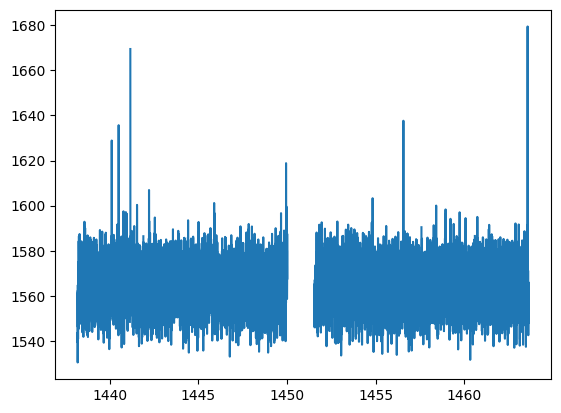

In [25]:
## TEMP ##
lc_fill = fill_times(lightcurve)
print(lc_fill.shape)
print(lc_fill.info())
plt.plot(lc_fill)

## Identify null_indices
null_indices = lc_fill.iloc[np.where(lc_fill.isna())[0]].index
print(null_indices[0:5])
print(null_indices.shape)

In [ ]:
## Cut down
lc_fill = lc_fill.iloc[0:1000]
# lc_fill = lc_fill.query("1447 <= index < 1453")
# lc_fill.shape

### Initial Imputation

In [ ]:
## Temp impute
lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())
print(lc_interp.shape)

(18856, 1)


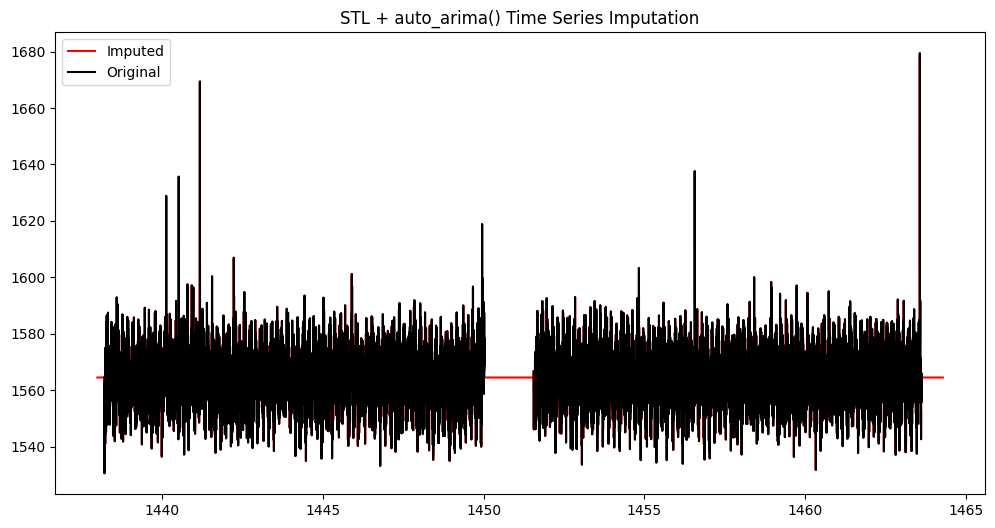

In [ ]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_interp, label='Imputed', color = "red")
plt.plot(lightcurve, label='Original', color = "black")
# plt.scatter(null_indices, lc_interp.loc[null_indices], label='Imputed', color = "steelblue", alpha = 0.8)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

### Model Imputation

In [ ]:
## TBATS ##
from tbats import TBATS, BATS

# Fit the model
estimator = TBATS(seasonal_periods=[240])
model_tbats = estimator.fit(lc_interp)

In [ ]:
print(model_tbats.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [240.]
Seasonal harmonics [2]
ARMA errors (p, q): (1, 1)
Smoothing (Alpha): 0.005500
Seasonal Parameters (Gamma): [0.01959426 0.00030727]
AR coefficients [0.00030727]
MA coefficients [0.04175802]
Seed vector [ 1.56414438e+03 -2.18363334e-01  7.90736201e-01 -3.85190996e-02
 -2.09425546e-01  0.00000000e+00  0.00000000e+00]

AIC 261452.600870


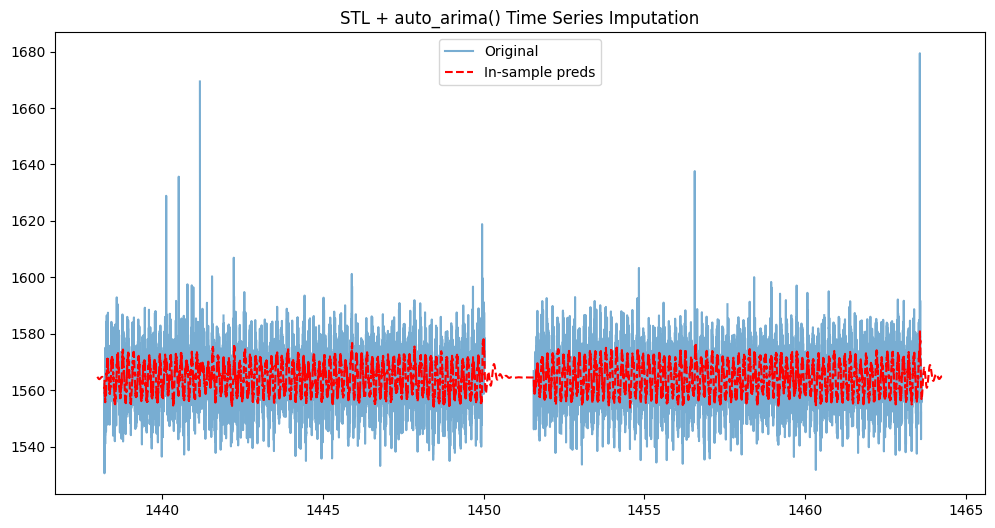

In [31]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_fill, label='Original', alpha=0.6)
plt.plot(lc_fill.index, model_tbats.y_hat, label='In-sample preds', linestyle='--', color='red')
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

In [ ]:
## LOG ##

## Run #2: lc_fill = lc_fill.query("1447 <= index < 1453")
# Best model:  ARIMA(4,0,4)(0,0,0)[5] intercept
# Total fit time: 1049.476 seconds
# Selected model order: (4, 0, 4) Seasonal order: (0, 0, 0, 5)

## Run #3: lc_fill = lc_fill.iloc[0:1000]
# Output before cutoff:
# Performing stepwise search to minimize aic
#  ARIMA(2,0,2)(1,0,1)[240] intercept   : AIC=inf, Time=1022.02 sec
#  ARIMA(0,0,0)(0,0,0)[240] intercept   : AIC=7135.422, Time=0.14 sec
#  ARIMA(1,0,0)(1,0,0)[240] intercept   : AIC=6972.780, Time=598.01 sec
#  ARIMA(0,0,1)(0,0,1)[240] intercept   : AIC=inf, Time=122.76 sec
#  ARIMA(0,0,0)(0,0,0)[240]             : AIC=17549.825, Time=0.02 sec
#  ARIMA(1,0,0)(0,0,0)[240] intercept   : AIC=6978.853, Time=0.15 sec

In [ ]:
## auto_arima
## Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Auto ARIMA
model_auto = auto_arima(
    lc_interp,
    start_p = 1, start_q = 1,
    d = 1,                      # d = 0 based on EDA
    max_p = 3, max_q = 3,
    start_P = 2, start_Q = 1,
    D = 1,
    max_P = 3, max_Q = 3,
    seasonal = True,
    m = 240,                    # m = number of periods in each season (Season = 1 day = 720 obs., Period = 240 obs. from EDA)
    stepwise = True,
    trace = True,
    suppress_warnings = True,
    error_action = "ignore"
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[240] intercept   : AIC=inf, Time=1022.02 sec
 ARIMA(0,0,0)(0,0,0)[240] intercept   : AIC=7135.422, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[240] intercept   : AIC=6972.780, Time=598.01 sec
 ARIMA(0,0,1)(0,0,1)[240] intercept   : AIC=inf, Time=122.76 sec
 ARIMA(0,0,0)(0,0,0)[240]             : AIC=17549.825, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[240] intercept   : AIC=6978.853, Time=0.15 sec


MemoryError: Unable to allocate 1.73 GiB for an array with shape (481, 481, 1001) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1015, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 1.73 GiB for an array with shape (481, 481, 1001) and data type float64


: 

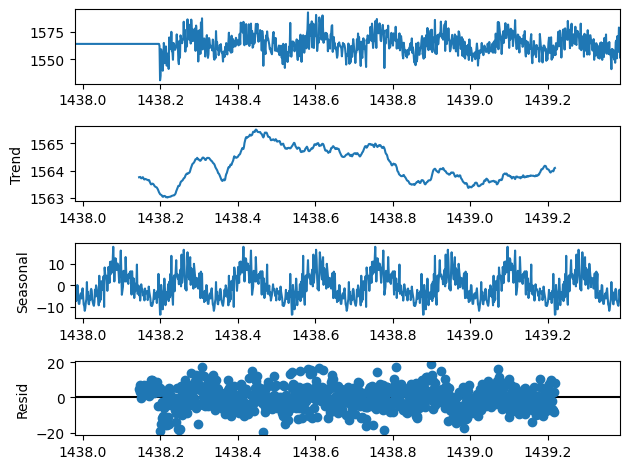

In [8]:
## ROUGH WORK ##
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())
result = seasonal_decompose(lc_interp, model='additive', period=240)
result.plot()
plt.show()

In [9]:
## BASE CODE ##
from statsmodels.tsa.statespace.sarimax import SARIMAX

## ChatGPT recommendations:
# p = 1, d = 1, q = 1
# P = 2, D = 1, Q = 1, s = 240
# d = 0 from ADF test
p, d, q = 1, 0, 1
P, D, Q, s = 2, 1, 1, 240

model = SARIMAX(
    lc_interp,
    order = (p, d, q),
    seasonal_order = (P, D, Q, s),
    enforce_stationarity = False,
    enforce_invertibility = False
)

sarimax_results = model.fit()

C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\alexd\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

In [ ]:
# results = model_auto.fit()

# print(results.summary())

NameError: name 'model_auto' is not defined

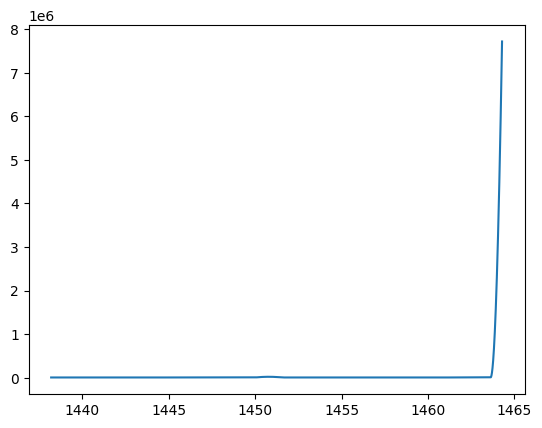

In [ ]:
## ROUGH WORK ##
# lc_interp = lc_fill.interpolate(method = "spline", order = 2)
# lc_interp.info()
# lc_interp.describe()
# plt.plot(lc_interp)

In [ ]:
## LOG ##
## basic (no exog)
# AIC: 130442.96071380268

## four_orders = 1
# AIC: 130593.5500357342

## four_orders = 2
# AIC: 130473.3564172449

## four_orders = 2
# AIC: 130628.79894223655

In [91]:
## ARIMA with Fourier terms ##
## Fourier terms
from pmdarima.preprocessing import FourierFeaturizer

four_order = 2
fourier_terms = FourierFeaturizer(240, four_order)
y_prime, exog = fourier_terms.fit_transform(lc_interp)
exog['time'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['time'])
exog = exog.drop(columns=['time'])
print(y_prime.head()); print(exog.head())
print((y_prime.shape, exog.shape))

             pdcsap_flux
1437.978646  1564.459684
1437.980034  1564.459684
1437.981423  1564.459684
1437.982812  1564.459684
1437.984201  1564.459684
             FOURIER_S240-0  FOURIER_C240-0  FOURIER_S240-1  FOURIER_C240-1
time                                                                       
1437.978646        0.026177        0.999657        0.052336        0.998630
1437.980034        0.052336        0.998630        0.104528        0.994522
1437.981423        0.078459        0.996917        0.156434        0.987688
1437.982812        0.104528        0.994522        0.207912        0.978148
1437.984201        0.130526        0.991445        0.258819        0.965926
((18856, 1), (18856, 4))


In [92]:
## auto_arima
## Suppress warnings for clean output
warnings.filterwarnings("ignore")

## Auto ARIMA
model_auto = auto_arima(
    y_prime,
    X=exog,
    trace=True,
    error_action='ignore'
)

print("Selected model order:", model_auto.order, "Seasonal order:", model_auto.seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=131397.355, Time=21.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=135683.487, Time=2.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=137444.699, Time=1.88 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=134068.232, Time=7.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=497678.416, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=130582.497, Time=17.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=133220.296, Time=10.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=130932.471, Time=12.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=130473.356, Time=20.90 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=132681.994, Time=9.46 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=131330.559, Time=23.20 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=131082.802, Time=24.18 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=132281.592, Time=13.11 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=131250.120, Time=27.08 

In [93]:
print(model_auto.fit_with_exog_)
print(model_auto.summary())
# print(model_auto_basic.fit_with_exog_)
# print(model_auto_basic.summary())

True
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18856
Model:               SARIMAX(1, 0, 3)   Log Likelihood              -65226.678
Date:                Mon, 24 Feb 2025   AIC                         130473.356
Time:                        17:06:32   BIC                         130551.802
Sample:                             0   HQIC                        130499.095
                              - 18856                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept        115.3848      7.614     15.154      0.000     100.461     130.308
FOURIER_S240-0    -0.2442      0.287     -0.850      0.395      -0.807       0.319
FOURIER_C240-0    -0.1715      

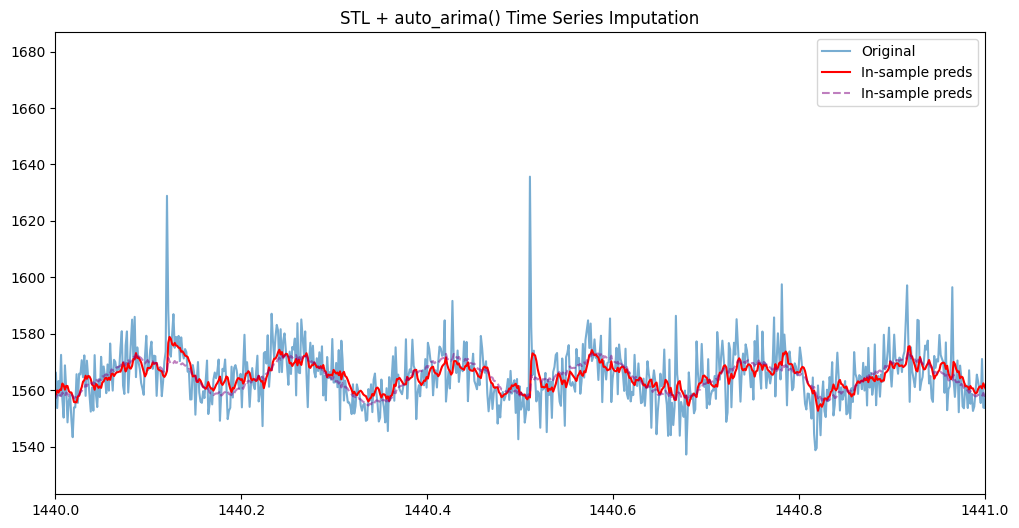

In [98]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lc_fill, label='Original', alpha=0.6)
plt.plot(lc_fill.index, model_auto.predict_in_sample(exog), label='In-sample preds', color='red')
plt.plot(lc_fill.index, model_tbats.y_hat, label='In-sample preds', linestyle='--', color='purple', alpha = 0.5)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.xlim((1440, 1441))
plt.show()

In [95]:
print(model_tbats.aic)
# print(model_auto_four1.aic)
print(model_auto.aic())

261452.60087041036
130473.3564172449


In [ ]:
# def sarima_impute():
#     ## 

#     return 1

In [141]:
d = model_auto.order[1]
pred_vals = model_auto.predict_in_sample(start = d, end = lc_fill.shape[0] - 1)
lc_fill.loc[null_indices[np.isin(null_indices, lc_fill.index[d:])], "pdcsap_flux"] = pred_vals[np.isin(lc_fill.index[d:], null_indices)] 

In [ ]:
## Check
lc_fill.shape
print(lc_fill.describe())
lc_fill.info()
print(lc_fill.index.max())

       pdcsap_flux
count  4313.000000
mean   1564.443354
std       8.051694
min    1534.878300
25%    1560.275300
50%    1564.441003
75%    1568.530500
max    1618.817300
<class 'pandas.core.frame.DataFrame'>
Float64Index: 4313 entries, 1447.000823172425 to 1452.9993977335207
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  4313 non-null   float64
dtypes: float64(1)
memory usage: 196.4 KB
1452.9993977335207
<class 'pandas.core.series.Series'>
Float64Index: 4313 entries, 1447.000823172425 to 1452.9993977335207
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
4313 non-null   float64
dtypes: float64(1)
memory usage: 67.4 KB


1823

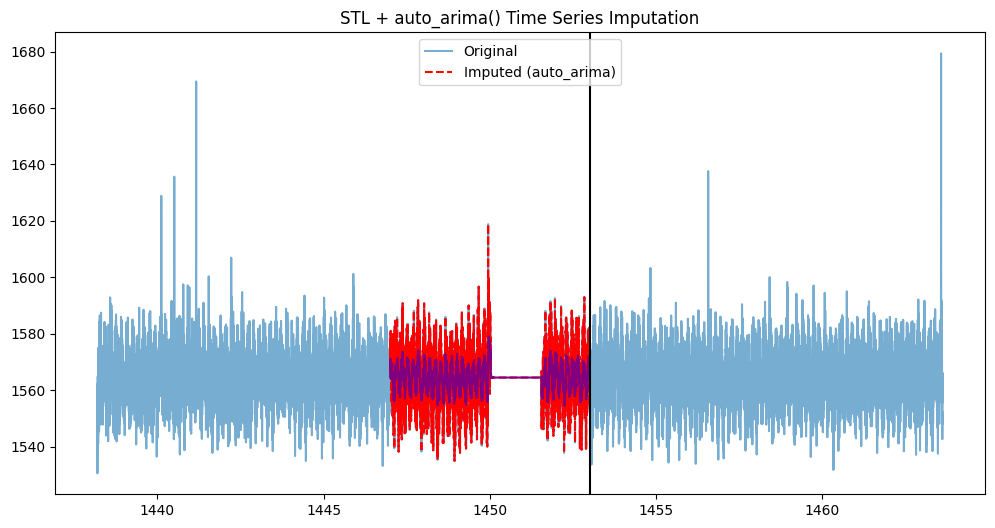

In [145]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', alpha=0.6)
plt.plot(lc_fill, label='Imputed (auto_arima)', linestyle='--', color='red')
plt.plot(pd.Series(pred_vals, index = lc_fill.index), color = "purple")
plt.axvline(lc_fill.index.max(), color = "black")
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()

In [192]:
## Save model
filename = "sarima_model.sav"
pickle.dump(model_auto, open(filename, 'wb'))

# ## Open model
# loaded_model = pickle.load(open(filename, 'rb'))

# STL Decomposition

(18856, 1)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pdcsap_flux  17033 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB
None


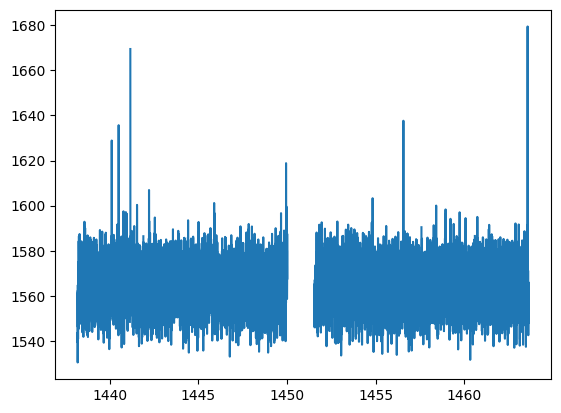

In [194]:
## TEMP ##
lc_fill = fill_times(lightcurve)
print(lc_fill.shape)
print(lc_fill.info())
plt.plot(lc_fill)

lc_interp = lc_fill.fillna(lc_fill["pdcsap_flux"].mean())

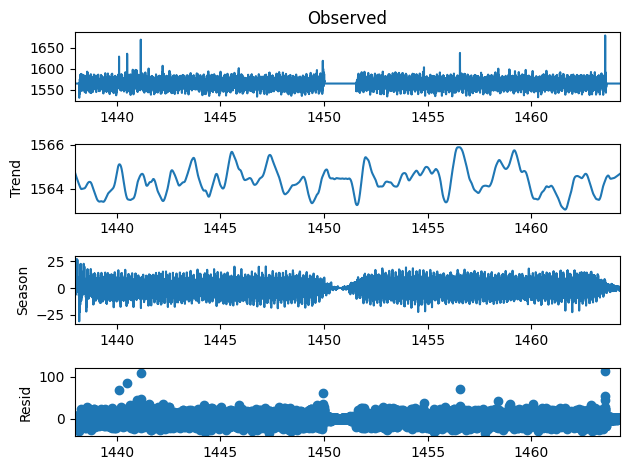

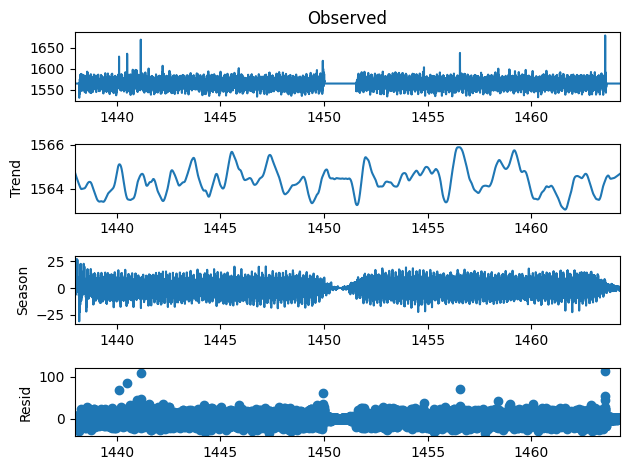

In [195]:
## STL Decomposition
stl = STL(lc_interp, period=240, robust=True)  # Use period=240 based on EDA
decomposition = stl.fit()

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## Plot
decomposition.plot()

In [196]:
# Check
residual.info(); residual.head(); residual.describe()

<class 'pandas.core.series.Series'>
Float64Index: 18856 entries, 1437.978645522663 to 1464.2854684532865
Series name: resid
Non-Null Count  Dtype  
--------------  -----  
18856 non-null  float64
dtypes: float64(1)
memory usage: 294.6 KB


count    18856.000000
mean         0.106673
std          6.714784
min        -34.267261
25%         -2.966608
50%          0.001416
75%          3.065438
max        113.875131
Name: resid, dtype: float64

In [197]:
## Save the imputed dataset
lc_fill["pdcsap_clean"] = residual #pdcsap_imputed
lc_fill["trend"] = trend
lc_fill["seasonal"] = seasonal
lc_fill.to_csv("../0.Data/031381302_imputed.csv")

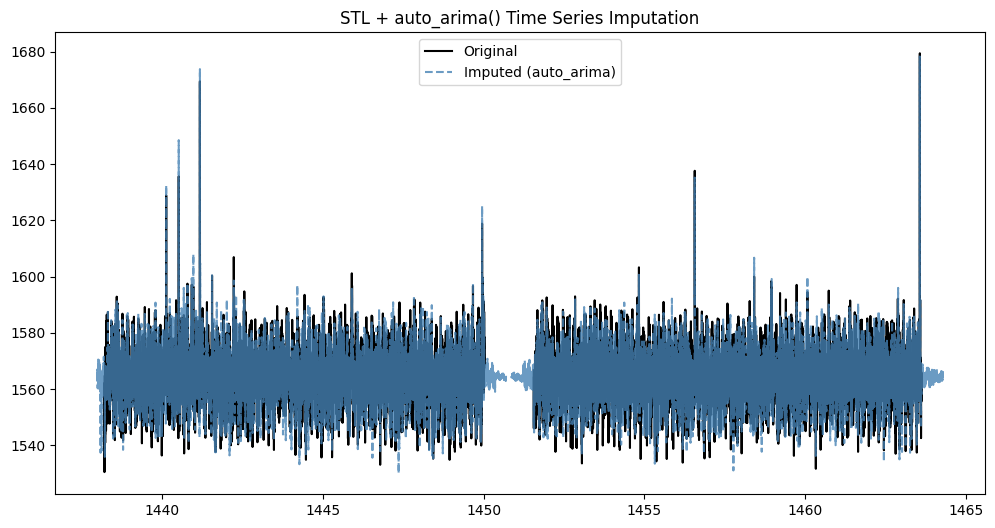

In [210]:
## Check
# Plot original vs imputed series
plt.figure(figsize=(12,6))
plt.plot(lightcurve, label='Original', color = "black")
plt.plot(lc_fill["pdcsap_clean"] + trend.mean(), label='Imputed (auto_arima)', linestyle='--', color = "steelblue", alpha = 0.8)
plt.title("STL + auto_arima() Time Series Imputation")
plt.legend()
plt.show()